In [1]:
import timeit

import numpy as np
import matplotlib.pyplot as plt

from scripts.queso_model import model_data, model_vars, objective_func, balance, alloc_df

# Enfriamiento Simulado

## Parámetros

In [2]:
# ¿Cómo se obtienen estas variables desde el sistema de información?

# Carpeta con los datos
folder = './data/test1/'
# Datos de centros de acopio
info_acopios = 'nuevo_info_acopios.xlsx'
# Matriz de costos de transporte entre CA
costo_transporte = 'costoTransporteCAi.xlsx'
# Matriz de tiempos de transporte entre CA
tiempo_transporte = 'tiempoTransporteCAi.xlsx'

# Carpeta con los datos
folder = './data/test3/'
# Datos de centros de acopio
info_acopios = 'info_acopios_escenario3.xlsx'
# Matriz de costos de transporte entre CA
costo_transporte = 'costo_transporte_escenario3.xlsx'
# Matriz de tiempos de transporte entre CA
tiempo_transporte = 'tiempos_transporte_escenario3.xlsx'

# Demanda del cliente
demanda = 60
# Costo por unidad de tiempo
ctiempo = 1000

# Temperatura inicial
max_anneal = 1.e10
# Temperatura final de enfriamiento (terminación)
min_anneal = 1.e-2
# Energía mínima (terminación)
energy = 3.5e5
# Ratio de enfriamiento
r_anneal = 0.996

In [3]:
archivos = {
    'info_acopios': info_acopios,
    'costo_transporte' : costo_transporte,
    'tiempo_transporte' : tiempo_transporte,
}

data = model_data(archivos, demanda, ctiempo, folder=folder)

demanda = data['demanda']
ctiempo = data['ctiempo']
# t_max = data['t_max']
params_df = data['params_df']

N, seed, capacidades = model_vars(params_df)

## Generación

Solución inicial $s_0$

In [4]:
# Generador del estado inicial
def gen_s0(n_vars):
    # Se indexan los centros de acopio
    gen_vector = np.zeros(n_vars+1, dtype=float)

    # Se reorganizan todos los índices de los centros de acopio, de forma aleatoria
    indices = np.arange(n_vars)
    np.random.shuffle(indices)

    while np.sum(gen_vector) < demanda and indices.size > 0:
        idx = indices[0]
        gen_vector[idx] += capacidades[idx]
        indices = np.delete(indices, 0)

        if np.sum(gen_vector) > demanda:
            gen_vector[idx] = gen_vector[idx] - (np.sum(gen_vector) - demanda)
            break

    gen_vector[n_vars] = np.random.randint(capacidades[n_vars] + 1)

    return gen_vector

Soluciones consecutivas $s_n$

In [5]:
def gen_s(sol):
    # Se toma un índice aleatorio
    idx = np.random.randint(sol.shape)
    
    # Si es el índice del centro de acopio principal (N*2)
    if idx == N*2:
        cap = sol[idx].astype(int)
        # Se escoge cualquier centro de acopio distinto al actual
        cap = np.delete(np.arange(capacidades[N*2]+1), cap)
        sol[idx] = np.random.choice(cap)
    else:
        # Asignación de centros de acopio sin el centro principal
        s = np.delete(sol, N*2)
        
        if s[idx] == 0:
            # Se asigna la máxima cantidad posible del índice
            delta = capacidades[idx]
            s[idx] = capacidades[idx]
            diff = True
        else:
            # Se asigna cero a la cantidad del índice
            delta = s[idx]
            s[idx] = 0
            diff = False
       
        balance(s, capacidades, delta, diff)
        sol = np.append(s, sol[N*2])

    return sol

Pseudocódigo del método de enfriamiento simulado implementado:

$$
\textit{Sea } s = s_0 \\ 
\textit{Mientras } t > t_{min}, e > e_{th}: \\
\qquad \text{Generar una nueva solución aleatoria, } s_{new} \leftarrow genS(s) \\ 
\qquad \textit{Si } f(s) > f(s_{new}): \\
\qquad \qquad \textit{entonces } s \leftarrow s_{new} \\
\qquad \textit{Sino:} \\
\qquad \qquad \textit{Si } P(f(s), f(s_{new}), t) \geq rand(0, 1): \\ 
\qquad \qquad \qquad \textit{entonces } s \leftarrow s_{new} \\
\text{Salida: } s_{final}
$$

In [6]:
def anneal(t, t_min, e_th, alpha):
    # Función objetivo
    f = objective_func
    # Estado inicial (s0)
    s = gen_s0(N*2)
    # función a optimizar (a.k.a energía, fitness)
    e = f(s, N, data)
    # Contador de iteraciones o pasos
    k = 0
    
    historial_f = []

    while t > t_min and e > e_th:
        s_new = gen_s(s)
        e_new = f(s_new, N, data)
        
        ' !!!!!!!! '
        historial_f.append(e_new)

        delta = e_new - e

        if delta < 0:
            s = s_new
            e = e_new
        else:
            p = np.exp(-delta / t)
            r = np.random.rand()

            if r < p:
                s = s_new
                e = e_new

        t *= alpha
        k += 1

    return s, k, historial_f


def sa(t_max, t_min, e_th, alpha, key=1):
    # np.random.seed(key)
    x, count, historial_f = anneal(t_max, t_min, e_th, alpha)
    print(f'Count: ', count)
    return x, historial_f

t_start_sa = timeit.default_timer()
annealing, historial = sa(max_anneal, min_anneal, energy, r_anneal)
t_end_sa = timeit.default_timer()

t_delta_sa = t_end_sa - t_start_sa


Count:  6894


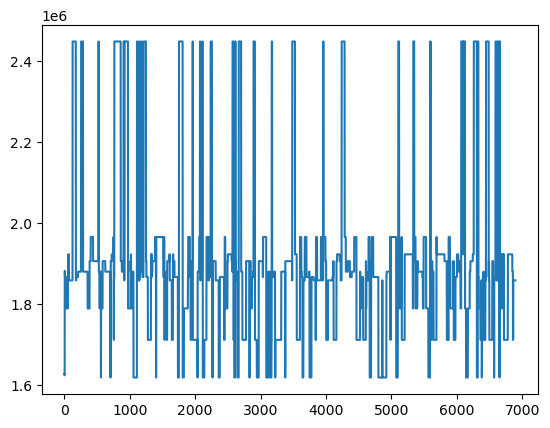

In [7]:
plt.plot(historial)
plt.show()

## Aplicación

In [8]:
print(f'Centro de acopio principal: {params_df['Id_CA'].iloc[int(annealing[N*2])]}')
print(f'Precio: {objective_func(annealing, N, data)}')
print(f'Tiempo: {round(t_delta_sa * 1000)}ms, ({t_delta_sa})')
print(np.min(historial))
print(annealing)

Centro de acopio principal: CA10
Precio: 1859069.0
Tiempo: 3514ms, (3.513883799998439)
1619636.0
[11.  5.  0.  0.  3.  0.  0.  0.  5.  7.  0.  0.  2.  7.  5.  0.  0. 15.
  0.  0.  9.]


In [9]:
asignaciones = alloc_df(annealing, params_df, N, capacidades)
asignaciones.head()

,index,CAcopio,Capacidad,Asignada
0,0,CA1 Stock,40.0,11.0
1,1,CA1 Potencial,5.0,5.0
2,2,CA2 Stock,0.0,0.0
3,3,CA2 Potencial,0.0,0.0
4,4,CA3 Stock,3.0,3.0


## Resultados

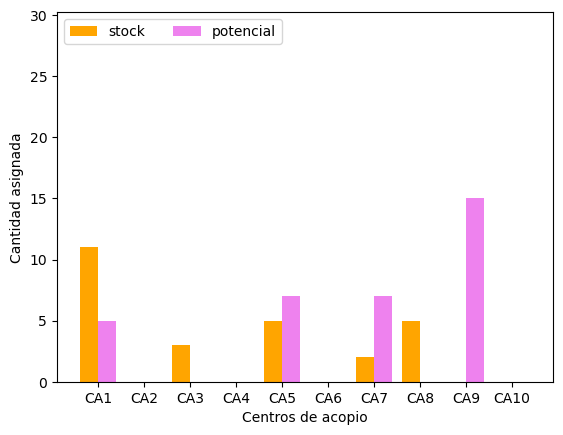

In [10]:
even = np.arange(0, N*2-1, 2)
odd = np.arange(1, N*2, 2)

cap_stock = np.take(capacidades, even)
cap_potencial = np.take(capacidades, odd)

ca_stock = np.take(annealing, even)
ca_potencial = np.take(annealing, odd)
    
labels = params_df['Id_CA']
x = np.arange(len(labels))
y1 = ca_stock
y2 = ca_potencial

_, ax = plt.subplots()
y_lim = np.array(np.mean([np.max(capacidades), np.max(annealing)])) * 1.1
ax.set_ylim([0, y_lim])
x1_bar = ax.bar(x-0.2, y1, width=0.4, label='stock', color='orange')
x2_bar = ax.bar(x+0.2, y2, width=0.4, label='potencial', color='violet')

plt.xticks(x, labels)
plt.xlabel('Centros de acopio')
plt.ylabel('Cantidad asignada')
plt.legend(loc='upper left', ncol=2)
plt.show()

C:\Users\Chef\AppData\Local\Temp\ipykernel_13176\43058111.py:3: RuntimeWarning: invalid value encountered in divide
  ca_stock_norm = ca_stock / cap_stock
C:\Users\Chef\AppData\Local\Temp\ipykernel_13176\43058111.py:4: RuntimeWarning: invalid value encountered in divide
  ca_potencial_norm = ca_potencial / cap_potencial


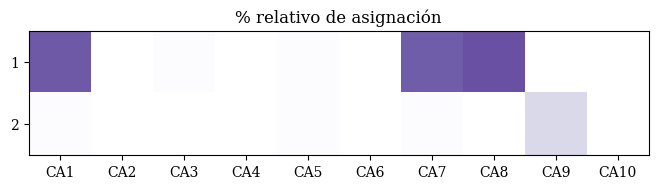

In [11]:
from pymoo.visualization.heatmap import Heatmap

ca_stock_norm = ca_stock / cap_stock
ca_potencial_norm = ca_potencial / cap_potencial
ca_heatmap = np.vstack((ca_stock_norm, ca_potencial_norm))

heatmap = Heatmap(bounds=(0, 1),
                  title='% relativo de asignación',
                  cmap='Purples',
                  labels=labels.values.tolist(),
                  y_labels=['Stock', 'Potencial'])
heatmap.add(ca_heatmap)
heatmap.show()

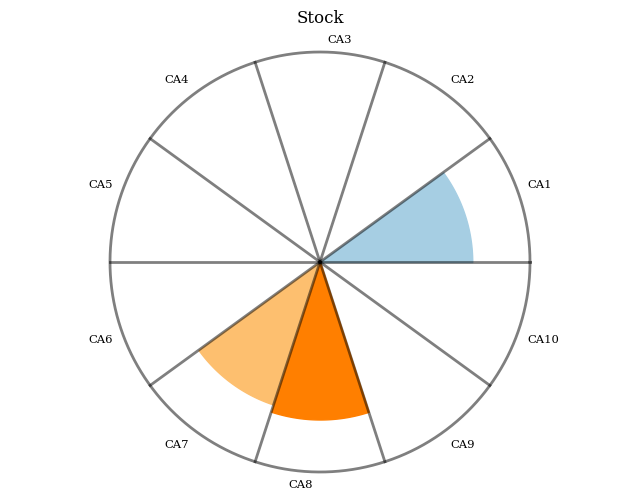

In [12]:
from pymoo.visualization.petal import Petal
# add both petals in a single graph?
petal = Petal(bounds=(0, 1),
              cmap='Paired',
              title='Stock',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_stock_norm)
petal.show()

In [13]:
petal = Petal(bounds=(0, 1),
              cmap='Set3_r',
              title='Potencial',
              labels=labels.values.tolist(),
              reverse=True)
petal.add(ca_potencial_norm)
# petal.show()

# todo

Comenzar a buscar parámetros óptimos y documentar los resultados (La solución es óptima?) 

Hacer varias ejecuciones y medir estadísticos sobre los resultados obtenidos (varianza)

In [14]:
evals = []
def sa_test(n):
    hist = []
    hist_t = []
    
    for i in range(n):
        
        t_i = timeit.default_timer()
        opt, graph = sa(max_anneal, min_anneal, energy, r_anneal)
        t_f = timeit.default_timer()

        evals.append(graph)
        
        t_delta = t_f - t_i
        hist.append(objective_func(opt, N, data))
        hist_t.append(t_delta)
        
    return hist, hist_t, n

history, hist_time, times = sa_test(5)
print(history, '\n', hist_time, '\n', times)

Count:  6894
Count:  6894
Count:  6894
Count:  6894
Count:  6894
[1940500.0, 2480600.0, 2391600.0, 1943000.0, 1908935.0] 
 [4.34353500000725, 3.2255160000058822, 3.1982806000014534, 3.2786994999914896, 3.275084600012633] 
 5


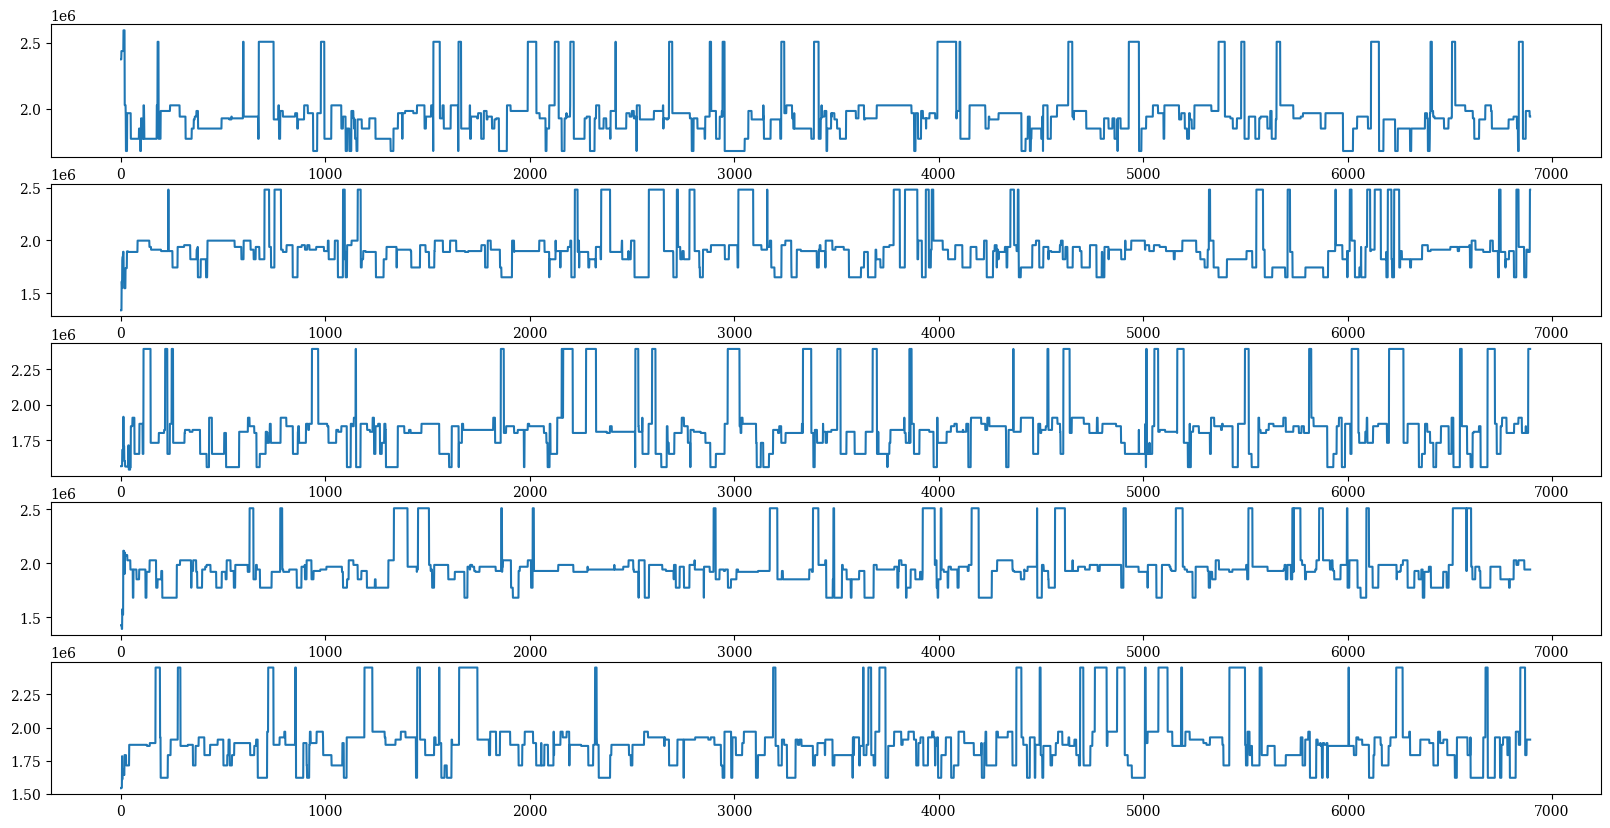

In [15]:
_, ax = plt.subplots(5, 1, figsize=(20, 10))

for m in range(5):
    ax[m].plot(evals[m])
plt.show()

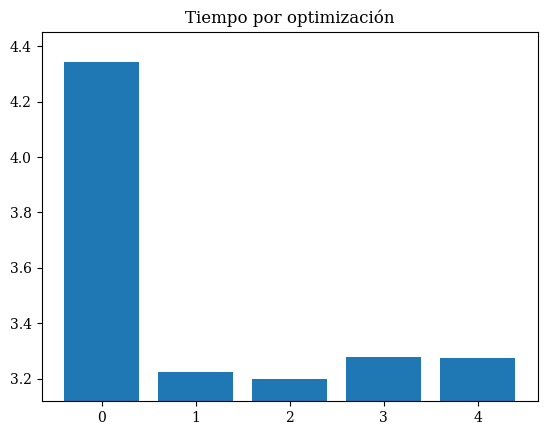

In [16]:
plt.bar(np.arange(times), hist_time)
plt.ylim([np.min(hist_time)*0.975, np.max(hist_time)*1.025])
plt.title('Tiempo por optimización')
plt.show()